In [40]:
import os.path
import math
import re
import tensorflow as tf
import numpy as np
import facenet
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_model_filenames(model_dir):
    files = os.listdir(model_dir)
    meta_files = [s for s in files if s.endswith('.meta')]
    if len(meta_files)==0:
        raise ValueError('No meta file found in the model directory (%s)' % model_dir)
    elif len(meta_files)>1:
        raise ValueError('There should not be more than one meta file in the model directory (%s)' % model_dir)
    meta_file = meta_files[0]
    meta_files = [s for s in files if '.ckpt' in s]
    max_step = -1
    for f in files:
        step_str = re.match(r'(^model-[\w\- ]+.ckpt-(\d+))', f)
        if step_str is not None and len(step_str.groups())>=2:
            step = int(step_str.groups()[1])
            if step > max_step:
                max_step = step
                ckpt_file = step_str.groups()[0]
    return meta_file, ckpt_file

def load_model(model, sess):
    model_exp = os.path.expanduser(model)
    print('Model directory: %s' % model_exp)
    meta_file, ckpt_file = get_model_filenames(model_exp)

    print('Metagraph file: %s' % meta_file)
    print('Checkpoint file: %s' % ckpt_file)

    saver = tf.train.import_meta_graph(os.path.join(model_exp, meta_file))
    saver.restore(sess, os.path.join(model_exp, ckpt_file))

In [3]:
def forward(paths, batch_size):
    nrof_images = len(paths)
    nrof_batches = int(math.ceil(1.0*nrof_images / batch_size))
    emb_array = np.zeros((nrof_images, embedding_size))

    for i in range(nrof_batches):    
        start_index = i*batch_size
        end_index = min((i+1)*batch_size, nrof_images)
        paths_batch = paths[start_index:end_index]
        images = facenet.load_data(paths_batch, False, False, image_size)
        feed_dict = { images_placeholder:images, phase_train_placeholder:False }
        emb_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)    
        print("batch number:", i)
    print("Complete")
    
    return emb_array

def printDistance(emb_array, label_list, end=10):
    threshold = 1.0
    lng = len(emb_array[:end])
    print('Distance matrix')
    print('    ', end='')
    for i in range(lng):
        print('    %3d     ' % i, end='')
    print('')
    for i in range(lng):
        print('%1d  ' % i, end='')
        for j in range(lng):
            dist = np.linalg.norm(emb_array[i,:] - emb_array[j,:])
            print('  %1.4f' % dist, end='')
            if (label_list[i] == label_list[j]) and (dist <= threshold):
                print("(TP)", end='')
            elif (label_list[i] != label_list[j]) and (dist > threshold):
                print("(TN)", end='')
            elif (label_list[i] == label_list[j]) and (dist > threshold):
                print("\033[93m(FN)\033[0m", end='')
            elif (label_list[i] != label_list[j]) and (dist <= threshold):
                print("\033[93m(FP)\033[0m", end='')
        print('')
        
def printData(labels, paths, number):
    for i in range(number):
        if i > 0 and labels[i] != labels[i-1]:
            print('')
        print('{0:3d} {1:3d}   {2:s}'.format(i, labels[i], paths[i].split("\\")[1]))
        # print('{0:3d}   {1:s}'.format(labels[i], paths[i].split("\\")[1]))
        
def PCAtransform(emb_array, n_components = 10):
    pca = PCA(n_components, whiten=True)
    pca.fit(emb_array)
    return pca.transform(emb_array), pca

def splitTrainTest(data_set, percent_train):
    paths, labels_list = facenet.get_image_paths_and_labels(data_set)
    
    lng = len(paths)
    lng_train = int(lng * percent_train / 100);
    lng_test = lng - lng_train
    
    train_paths = paths[0:lng_train]
    test_paths = paths[lng_train:]
    
    train_labels = labels_list[0:lng_train]
    test_labels = labels_list[lng_train:]
    
    return train_paths, train_labels, test_paths, test_labels

def trainFisher(emb_array, y):
    emb_del = np.empty_like(emb_array)
    np.copyto(emb_del, emb_array)
    
    emb_array = np.vstack((emb_array, y))
    
    # y = emb_array[sample_number]
    # emb_del = np.delete(emb_array, (sample_number), axis=0)
    
    E = np.linalg.inv(np.cov(emb_array.T))
    D = (y - (1 / (len(emb_array) - 1) * np.sum(emb_del)))
    
    w = np.dot(E, D)
    c = np.dot(w / np.linalg.norm(w), y)
    
    return c, w

def trainFisherWithNum(emb_array, sample_number):    
    y = emb_array[sample_number]
    emb_del = np.delete(emb_array, (sample_number), axis=0)
    
    E = np.linalg.inv(np.cov(emb_array.T))
    D = (y - (1 / (len(emb_array) - 1) * np.sum(emb_del)))
    
    w = np.dot(E, D)
    c = np.dot(w / np.linalg.norm(w), y)
    
    return c, w    

def Fisher(w, c, sample):
    return np.dot(w / np.linalg.norm(w), sample) - c

In [144]:
def whiten(X, fudge=1E-18):
    # the matrix X should be observations-by-components

    # get the covariance matrix
    Xcov = np.dot(X.T, X)

    # eigenvalue decomposition of the covariance matrix
    d, V = np.linalg.eigh(Xcov)

    # a fudge factor can be used so that eigenvectors associated with
    # small eigenvalues do not get overamplified.
    D = np.diag(1. / np.sqrt(d+fudge))

    # whitening matrix
    W = np.dot(np.dot(V, D), V.T)

    # multiply by the whitening matrix
    X_white = np.dot(X, W)

    return X_white, W

In [4]:
sess = tf.Session()

In [5]:
data_set = facenet.get_dataset("../../datasets/ownpeople/ownpeople_mtcnnpy_160/")

In [6]:
train_paths, train_labels, test_paths, test_labels = splitTrainTest(data_set, 100)

In [7]:
load_model("20170511-185253", sess)

Model directory: 20170511-185253
Metagraph file: model-20170511-185253.meta
Checkpoint file: model-20170511-185253.ckpt-80000
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from 20170511-185253\model-20170511-185253.ckpt-80000


In [8]:
images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

image_size = 160
embedding_size = embeddings.get_shape()[1]

In [152]:
emb_array = forward(train_paths, 100) # 100 means 100 mini-batches

batch number: 0
Complete


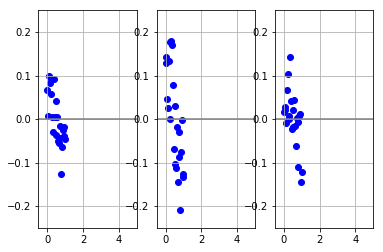

In [149]:
# Centering data

mean = emb_array.mean(axis=0)
emb_array = emb_array - mean

fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.grid(True)
ax1.set_xlim([-0.5, 5])
ax1.set_ylim([-0.25, 0.25])
ax2.grid(True)
ax2.set_xlim([-0.5, 5])
ax2.set_ylim([-0.25, 0.25])
ax3.grid(True)
ax3.set_xlim([-0.5, 5])
ax3.set_ylim([-0.25, 0.25])

ax1.plot(np.linspace(-0.5,5,num=23), np.zeros((23)), color="gray")
ax1.scatter(np.linspace(0,1,23), emb_array[:, 1], color="blue")

ax2.plot(np.linspace(-0.5,5,num=23), np.zeros((23)), color="gray")
ax2.scatter(np.linspace(0,1,23), emb_array[:, 10], color="blue")

ax3.plot(np.linspace(-0.5,5,num=23), np.zeros((23)), color="gray")
ax3.scatter(np.linspace(0,1,23), emb_array[:, 127], color="blue")

In [176]:
# Whitening data
emb_array, _ = whiten(emb_array, 1E-12)

In [177]:
# Copying for save the original array
emb_origin = np.empty_like(emb_array)
np.copyto(emb_origin, emb_array)

In [178]:
emb_pca, _ = PCAtransform(emb_array, 100)
origin_pca, _ = PCAtransform(emb_origin, 100)

In [179]:
printData(train_labels, train_paths, 23)

  0   1   photo_2016-11-04_19-33-44.png
  1   1   photo_2016-11-19_23-42-00.png
  2   1   photo_2016-12-25_20-59-04.png
  3   1   photo_2016-12-25_20-59-23.png
  4   1   photo_2017-03-10_12-46-19.png
  5   1   photo_2017-05-23_21-38-22.png
  6   1   photo_2017-08-26_20-24-22.png
  7   1   photo_2017-09-08_15-05-01.png
  8   1   photo_2017-10-24_15-01-13.png
  9   1   photo_2017-10-31_16-36-11.png

 10   3   photo_2016-07-04_22-38-35.png
 11   3   photo_2016-07-12_13-26-07.png
 12   3   photo_2016-07-21_00-38-16.png
 13   3   photo_2016-12-12_17-25-22.png
 14   3   photo_2017-01-14_20-14-58.png
 15   3   photo_2017-05-19_00-35-56.png
 16   3   photo_2017-07-15_17-05-07.png
 17   3   photo_2017-07-23_23-45-38.png
 18   3   photo_2017-09-18_12-12-13.png
 19   3   photo_2017-09-26_00-32-31.png
 20   3   photo_2017-11-17_01-42-09.png
 21   3   photo_2017-11-17_01-42-51.png
 22   3   photo_2017-11-17_01-43-40.png


In [180]:
# Cut false positives

In [181]:
emb_del = np.empty_like(emb_array)

In [186]:
arr = emb_array

lng = len(arr)
summ = 0
threshold = 1.41

for i in range(lng):
    for j in range(i, lng):
        dist = np.linalg.norm(arr[i,:] - arr[j,:])
        if (train_labels[i] == train_labels[j]) and (dist > threshold):
            print(i,j,train_labels[i],train_labels[j], dist, "FN")
        elif (train_labels[i] != train_labels[j]) and (dist <= threshold):
            print(i,j,train_labels[i],train_labels[j], dist, "FP")

0 1 1 1 1.41421356236 FN
0 2 1 1 1.41421356238 FN
0 3 1 1 1.41421356238 FN
0 4 1 1 1.41421356235 FN
0 5 1 1 1.41421356242 FN
0 6 1 1 1.41421356239 FN
0 7 1 1 1.41421356234 FN
0 8 1 1 1.41421356243 FN
0 9 1 1 1.41421356241 FN
1 2 1 1 1.41421356234 FN
1 3 1 1 1.41421356239 FN
1 4 1 1 1.41421356238 FN
1 5 1 1 1.41421356239 FN
1 6 1 1 1.41421356235 FN
1 7 1 1 1.41421356236 FN
1 8 1 1 1.41421356239 FN
1 9 1 1 1.41421356239 FN
2 3 1 1 1.41421356237 FN
2 4 1 1 1.41421356238 FN
2 5 1 1 1.41421356236 FN
2 6 1 1 1.41421356238 FN
2 7 1 1 1.41421356234 FN
2 8 1 1 1.41421356234 FN
2 9 1 1 1.41421356238 FN
3 4 1 1 1.41421356242 FN
3 5 1 1 1.4142135624 FN
3 6 1 1 1.41421356239 FN
3 7 1 1 1.41421356234 FN
3 8 1 1 1.41421356244 FN
3 9 1 1 1.41421356247 FN
4 5 1 1 1.41421356242 FN
4 6 1 1 1.41421356235 FN
4 7 1 1 1.41421356233 FN
4 8 1 1 1.41421356239 FN
4 9 1 1 1.41421356239 FN
5 6 1 1 1.41421356242 FN
5 7 1 1 1.41421356236 FN
5 8 1 1 1.41421356237 FN
5 9 1 1 1.41421356237 FN
6 7 1 1 1.4142135623 FN
6 

In [19]:
emb_del = np.delete(emb_array, (10, 11, 13, 19, 22), axis=0)

In [20]:
c, w = trainFisherWithNum(emb_del, 10)

In [21]:
for i in range(len(emb_array)):
    l = np.around(Fisher(w, c, emb_array[i]), decimals=6)
    print(i, l)

0 -0.0
1 -0.0
2 0.0
3 0.0
4 0.0
5 -0.0
6 0.0
7 -0.0
8 -0.0
9 -0.0
10 0.001197
11 0.083887
12 0.0
13 -0.009053
14 -0.0
15 0.0
16 -0.0
17 -0.0
18 -0.0
19 -0.022825
20 -0.0
21 -0.0
22 -0.003497
